In [23]:
# Import findspark
import findspark
findspark.init()

# Import pyspark
from pyspark import SparkFiles

# Import pyspark sql functions
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when
from pyspark.sql.functions import when, col
from pyspark.sql.functions import when


# Import Pandas and Numpy
import pandas as pd
import numpy as np

# Import Sklearn for model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Import StandardScaler for scaling numeric features
from sklearn.preprocessing import StandardScaler

# Import Matplot and seaborn for graphing
import matplotlib.pyplot as plt
import seaborn as sns


# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("sparkFunctions").getOrCreate()

In [24]:
from pyspark import SparkFiles
csv_file_paths = [
    "Resources/CurrentPopulationSurvey_1981.csv",
    "Resources/CurrentPopulationSurvey_1990.csv",
    "Resources/CurrentPopulationSurvey_1999.csv",
    "Resources/CurrentPopulationSurvey_2007.csv",
    "Resources/CurrentPopulationSurvey_2009.csv",
    "Resources/CurrentPopulationSurvey_2011.csv",
    "Resources/CurrentPopulationSurvey_2013.csv"
]

dfs = [spark.read.csv(path, sep=",", header=True, ignoreLeadingWhiteSpace=True) for path in csv_file_paths]

combined_df = dfs[0]
for df in dfs [1:]:
    combined_df = combined_df.union(df)

# Show DataFrame
combined_df.show(5)

+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+
|year|          state name| region_1|age|sex_1|       race_1|      martial status|union type|educ99|occ|ind|wkswork1|uhrswork|incwage|
+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+
|1981|            Virginia|    South| 38| male|Other nonhisp|Married, spouse p...|      NULL|  NULL|245|798|      52|      40|17000.0|
|1981|             Vermont|Northeast| 58| male|White nonhisp|Married, spouse p...|      NULL|  NULL|470|339|      52|      48|19000.0|
|1981|                Utah|     West| 35| male|White nonhisp|Married, spouse p...|      NULL|  NULL|715|417|      52|      43|21000.0|
|1981|            Illinois|  Midwest| 33| male|White nonhisp|            Divorced|      NULL|  NULL|485|857|      52|      60|19740.0|
|1981|District of Columbia|    South| 45| male|Black no

In [25]:
#Create a Python dictionary to store CPI values for each year
cpi_dict = {
    1981: 87.00,
    1990: 127.40,
    1999: 164.30,
    2007: 202.416,
    2009: 211.143,
    2011: 220.223,
    2013: 230.280
}

# base year for inflation adjustment 
base_year_cpi = cpi_dict[2013]

# Adjust 'incwage' for inflation based on the CPI values
real_wage_data = combined_df.withColumn(
    'real_wage', 
    when(col('year') == 1981, (col('incwage') / cpi_dict[1981]) * base_year_cpi)
    .when(col('year') == 1990, (col('incwage') / cpi_dict[1990]) * base_year_cpi)
    .when(col('year') == 1999, (col('incwage') / cpi_dict[1999]) * base_year_cpi)
    .when(col('year') == 2007, (col('incwage') / cpi_dict[2007]) * base_year_cpi)
    .when(col('year') == 2009, (col('incwage') / cpi_dict[2009]) * base_year_cpi)
    .when(col('year') == 2011, (col('incwage') / cpi_dict[2011]) * base_year_cpi)
    .when(col('year') == 2013, (col('incwage') / cpi_dict[2013]) * base_year_cpi)
    .otherwise(col('incwage'))  # In case any year falls outside the defined years
)

# Show the updated rows with the real wages
real_wage_data.show(5)

+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+------------------+
|year|          state name| region_1|age|sex_1|       race_1|      martial status|union type|educ99|occ|ind|wkswork1|uhrswork|incwage|         real_wage|
+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+------------------+
|1981|            Virginia|    South| 38| male|Other nonhisp|Married, spouse p...|      NULL|  NULL|245|798|      52|      40|17000.0| 44997.24137931035|
|1981|             Vermont|Northeast| 58| male|White nonhisp|Married, spouse p...|      NULL|  NULL|470|339|      52|      48|19000.0| 50291.03448275862|
|1981|                Utah|     West| 35| male|White nonhisp|Married, spouse p...|      NULL|  NULL|715|417|      52|      43|21000.0|  55584.8275862069|
|1981|            Illinois|  Midwest| 33| male|White nonhisp|            Div

In [26]:
# Calculate average wages by gender and year
avg_wage_by_gender_year = real_wage_data.groupBy('year', 'sex_1').agg({'real_wage': 'mean'})

# Pivot the table to get separate columns for male and female wages
pay_gap = avg_wage_by_gender_year.groupBy('year').pivot('sex_1').agg({'avg(real_wage)': 'mean'})

# Calculate pay gap: Difference between male and female average wages
pay_gap = pay_gap.withColumn('PayGap', pay_gap['male'] - pay_gap['female'])

# Order by 'year' after calculating the pay gap
pay_gap = pay_gap.orderBy('year')

# Show the results
pay_gap.show(5)

+----+------------------+------------------+------------------+
|year|            female|              male|            PayGap|
+----+------------------+------------------+------------------+
|1981|26200.225486950847| 51526.80137115999|25326.575884209145|
|1990|32133.479079493907| 53983.27308826582|21849.794008771914|
|1999| 36667.03188183436|58973.274545825734|22306.242663991376|
|2007|40871.004826902616|63641.132025883824| 22770.12719898121|
|2009| 41611.57857214943|64542.330664655194| 22930.75209250576|
+----+------------------+------------------+------------------+
only showing top 5 rows



In [27]:
# Analyzing pay gap by age group

# Create age brackets
real_wage_data = real_wage_data.withColumn(
    'AgeBracket',
    when((real_wage_data['age'] >= 20) & (real_wage_data['age'] < 30), '20-30')
    .when((real_wage_data['age'] >= 30) & (real_wage_data['age'] < 40), '30-40')
    .when((real_wage_data['age'] >= 40) & (real_wage_data['age'] < 50), '40-50')
    .otherwise('50+')
)

# Calculate average wages by gender and age bracket
pay_gap_by_age = real_wage_data.groupBy('AgeBracket', 'sex_1').agg({'real_wage': 'mean'}).orderBy('AgeBracket')
pay_gap_by_age.show()

+----------+------+------------------+
|AgeBracket| sex_1|    avg(real_wage)|
+----------+------+------------------+
|     20-30|female| 30318.15163110477|
|     20-30|  male|39342.613101695664|
|     30-40|female| 36953.09538304095|
|     30-40|  male| 56204.86917530093|
|     40-50|  male| 67553.34472535251|
|     40-50|female| 40541.53404475129|
|       50+|female| 40293.01140186898|
|       50+|  male| 66209.95275574058|
+----------+------+------------------+



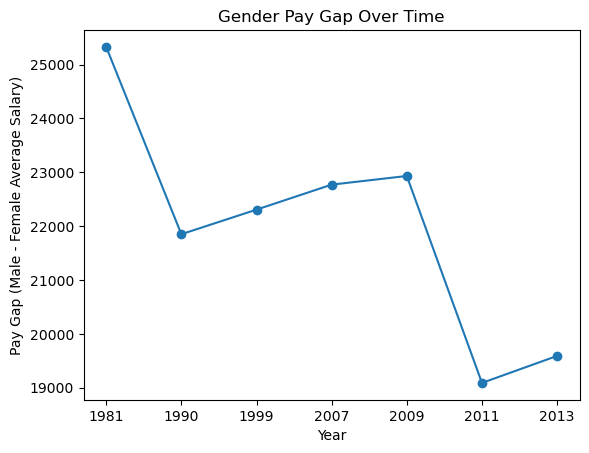

In [28]:
# Convert Spark DataFrame to Pandas for visualization
pay_gap_pandas = pay_gap.toPandas()

# Plot the gender pay gap over time
plt.plot(pay_gap_pandas['year'], pay_gap_pandas['PayGap'], marker='o')
plt.title('Gender Pay Gap Over Time')
plt.xlabel('Year')
plt.ylabel('Pay Gap (Male - Female Average Salary)')
plt.show()

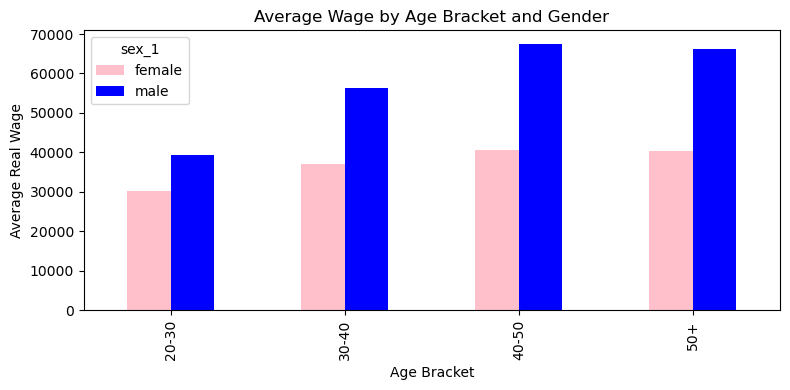

In [29]:
# Convert Spark DataFrame to Pandas
pay_gap_by_age_pd = pay_gap_by_age.toPandas()

# Pivot the DataFrame to have separate columns for male and female real wages
pay_gap_by_age_pivot = pay_gap_by_age_pd.pivot(index='AgeBracket', columns='sex_1', values='avg(real_wage)').fillna(0)

# Set up the plot with the new pivoted DataFrame
ax = pay_gap_by_age_pivot.plot(kind='bar', stacked=False, figsize=(8, 4), color=['pink', 'blue'])

# Set plot labels and title
plt.title('Average Wage by Age Bracket and Gender')
plt.xlabel('Age Bracket')
plt.ylabel('Average Real Wage')

# Display the plot
plt.tight_layout()
plt.show()

In [30]:

# Step 1: Group by occupation and gender, and calculate the average salary
occupations = real_wage_data.groupBy(['occ', 'sex_1']).agg(F.mean('real_wage').alias('avg_salary'))

# Step 2: Pivot the DataFrame to get male and female salaries in separate columns
occupations_pivoted = occupations.groupBy('occ').pivot('sex_1').agg(F.first('avg_salary')).na.fill(0)

# Step 3: Calculate total salary (sum of male and female average salaries) and get top 10 occupations
occupations_pivoted = occupations_pivoted.withColumn('total_salary', occupations_pivoted['male'] + occupations_pivoted['female'])
top_occupations = occupations_pivoted.orderBy('total_salary', ascending=False).limit(10)

# Drop rows where 'occ' is 66, 1520 or 84 (difficulty finding occ codes)
top_occupations = top_occupations[~top_occupations['occ'].isin([66, 84, 1520])]

# Verify that the rows were dropped
top_occupations.head(8)


[Row(occ='3060', female=143920.7629554128, male=226480.12369363668, total_salary=370400.88664904947),
 Row(occ='10', female=127482.20915185273, male=184096.63110707406, total_salary=311578.8402589268),
 Row(occ='2100', female=125707.48322237715, male=181693.26327849666, total_salary=307400.7465008738),
 Row(occ='1800', female=135396.45647439995, male=153717.15237753253, total_salary=289113.60885193245),
 Row(occ='3010', female=111030.20629405118, male=175785.67576427708, total_salary=286815.88205832825),
 Row(occ='3256', female=136872.0099008732, male=141467.89081975998, total_salary=278339.9007206332),
 Row(occ='1200', female=123046.55075368396, male=153825.3699617469, total_salary=276871.92071543087)]

In [31]:
# Step 4: Convert to Pandas DataFrame for plotting
top_occupations_pd = top_occupations.toPandas()

# Step 5: Replace 'occ' numeric values with descriptive labels
occupation_mapping = {
    3060: 'Physician',
    10: 'CEO',
    2100: 'Lawyer',
    1800: 'Economist',
    3010: 'Dentist',
    3256: 'Nurse Anesthetists',
    1200: 'Actuary',
    1520: 'Petroleum Engineer'
}
# Ensure the 'occ' column is cast to integer before replacing
top_occupations_pd['occ'] = top_occupations_pd['occ'].astype(int)

# Replace all 'occ' values with descriptive names from the mapping dictionary
top_occupations_pd['occ'] = top_occupations_pd['occ'].replace(occupation_mapping)
top_occupations_pd.head(10)

,occ,female,male,total_salary
0,Physician,143920.762955,226480.123694,370400.886649
1,CEO,127482.209152,184096.631107,311578.840259
2,Lawyer,125707.483222,181693.263278,307400.746501
3,Economist,135396.456474,153717.152378,289113.608852
4,Dentist,111030.206294,175785.675764,286815.882058
5,Nurse Anesthetists,136872.009901,141467.890820,278339.900721
6,Actuary,123046.550754,153825.369962,276871.920715


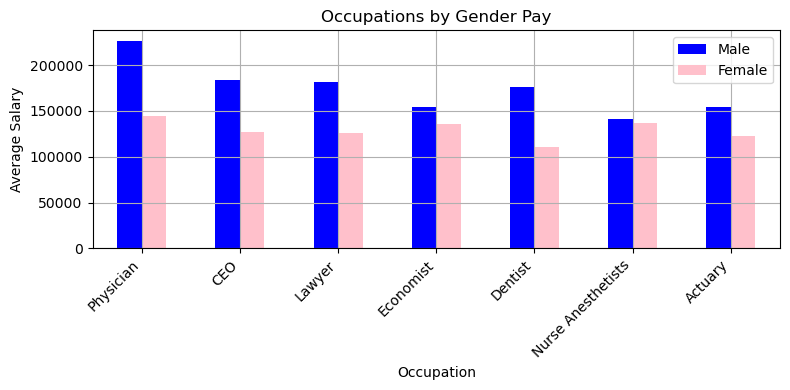

In [32]:
# Step 6: Plot the top 10 occupations with a bar chart using descriptive labels
top_occupations_pd.set_index('occ')[['male', 'female']].plot(kind='bar', stacked=False, figsize=(8, 4), color=['blue', 'pink'])

# Tilt the x-axis labels
plt.xticks(rotation=45, ha='right')

# Step 7: Add labels and title
plt.title('Occupations by Gender Pay')
plt.xlabel('Occupation')
plt.ylabel('Average Salary')
plt.legend(['Male', 'Female'], loc='upper right')
plt.grid(True)

# Step 8: Show the plot
plt.tight_layout()
plt.show()

In [33]:

# Step 1: Filter for women (assuming 'sex_1' = 'female' represents women)
women_occupations = real_wage_data.filter(real_wage_data['sex_1'] == 'female')

# Step 2: Group by occupation code and calculate the count of women and average real wage
women_occupation_stats = women_occupations.groupBy('occ').agg(
    F.count('*').alias('count'),
    F.mean('real_wage').alias('avg_real_wage')
)

# Step 3: Order by the number of women in each occupation (descending) and get the top 10
top_women_occupations = women_occupation_stats.orderBy('count', ascending=False).limit(10)

# Step 4: Drop rows where 'occ' is 313, 3130, 4700(for filtering out specific occupations)
top_women_occupations = top_women_occupations.filter(~top_women_occupations['occ'].isin([313, 3130, 4700]))

# Step 5: Convert to Pandas for verification or further analysis
top_women_occupations = top_women_occupations.toPandas()

# Step 6: Show the top 8 rows
print(top_women_occupations.head(8))



    occ  count  avg_real_wage
0  5700   5414   35357.415812
1  2310   4883   45317.675830
2  3600   2919   23695.796025
3  3255   2515   59538.986258
4  4720   2368   17987.138296
5  5240   2152   34135.185578
6  4230   2108   17921.682387


In [34]:
# Step 5: Replace 'occ' numeric values with descriptive labels
occ_women_mapping = {
    5700: 'Secretary',
    2310: 'Teacher',
    3600: 'Nurses Aide',
    3255: 'Registered Nurse',
    4720: 'Cashier',
    5240: 'Customer Service Representative',
    4230: 'Maid'
}
# Ensure the 'occ' column is cast to integer before replacing
top_women_occupations['occ'] = top_women_occupations['occ'].astype(int)

# Replace all 'occ' values with descriptive names from the mapping dictionary
top_women_occupations['occ'] = top_women_occupations['occ'].replace(occ_women_mapping)
top_women_occupations.head()

,occ,count,avg_real_wage
0,Secretary,5414,35357.415812
1,Teacher,4883,45317.675830
2,Nurses Aide,2919,23695.796025
3,Registered Nurse,2515,59538.986258
4,Cashier,2368,17987.138296


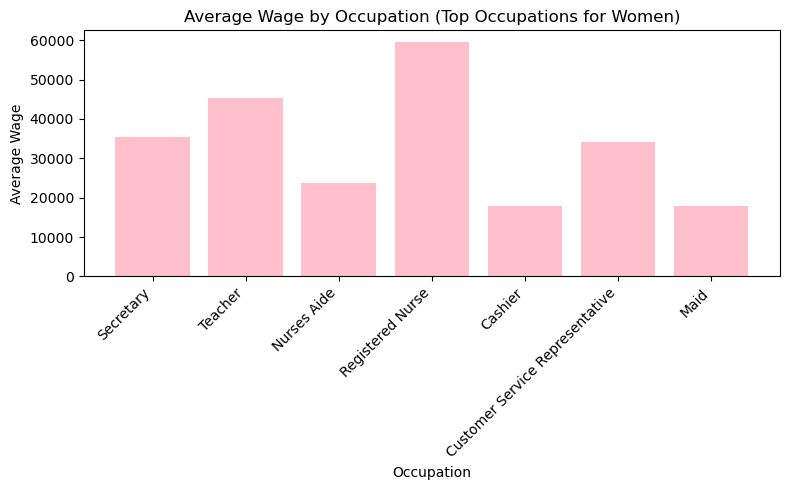

In [45]:
# Step 7: Plot the graph
plt.figure(figsize=(8, 5))
plt.bar(top_women_occupations['occ'], top_women_occupations['avg_real_wage'], color='pink')
plt.xlabel('Occupation')
plt.ylabel('Average Wage')
plt.title('Average Wage by Occupation (Top Occupations for Women)')
plt.xticks(rotation=45, ha='right')  # Tilt the x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [46]:
# Step 1: Filter for women (assuming 'sex_1' = 'female' represents women)
men_occupations = real_wage_data.filter(real_wage_data['sex_1'] == 'male')

# Step 2: Group by occupation code and calculate the count of women and average real wage
men_occupation_stats = men_occupations.groupBy('occ').agg(
    F.count('*').alias('count'),
    F.mean('real_wage').alias('avg_real_wage')
)

# Step 3: Order by the number of women in each occupation (descending) and get the top 10
top_men_occupations = men_occupation_stats.orderBy('count', ascending=False).limit(10)

# Step 4: Drop rows where 'occ' is 245, 19, 4700(for filtering out specific occupations)
top_men_occupations = top_men_occupations.filter(~top_men_occupations['occ'].isin([245, 19, 4700]))

# Step 5: Convert to Pandas for verification or further analysis
top_men_occupations = top_men_occupations.toPandas()

# Step 6: Show the top 8 rows
print(top_men_occupations.head(8))

    occ  count  avg_real_wage
0  9130   4918   44751.837132
1   430   3143   89548.016678
2  4220   2286   28793.194728
3  9620   1964   31899.031291
4  4760   1723   50595.392361
5  6260   1675   33138.059027
6   804   1628   44130.121854


In [47]:
# Step 5: Replace 'occ' numeric values with descriptive labels
occ_men_mapping = {
    9130: 'Truck Driver',
    430: 'Manager',
    4220: 'Janitor',
    9620: 'Laborer',
    4760: 'Sales',
    6260: 'Construction',
    804: 'Accountant',
}
# Ensure the 'occ' column is cast to integer before replacing
top_men_occupations['occ'] = top_men_occupations['occ'].astype(int)

# Replace all 'occ' values with descriptive names from the mapping dictionary
top_men_occupations['occ'] = top_men_occupations['occ'].replace(occ_men_mapping)
top_men_occupations.head()

,occ,count,avg_real_wage
0,Truck Driver,4918,44751.837132
1,Manager,3143,89548.016678
2,Janitor,2286,28793.194728
3,Laborer,1964,31899.031291
4,Sales,1723,50595.392361


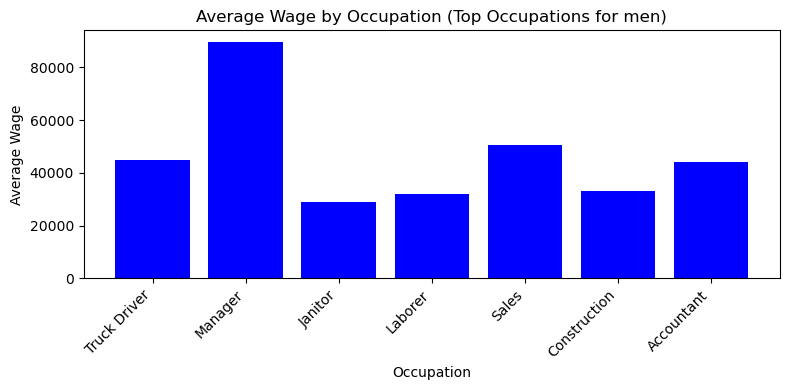

In [49]:
# Step 7: Plot the graph
plt.figure(figsize=(8, 4))
plt.bar(top_men_occupations['occ'], top_men_occupations['avg_real_wage'], color='blue')
plt.xlabel('Occupation')
plt.ylabel('Average Wage')
plt.title('Average Wage by Occupation (Top Occupations for men)')
plt.xticks(rotation=45, ha='right')  # Tilt the x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
# Creating the Randomforest Regression:

# Calculate the average salary by year, state name, race, age, union type, and marital status
avg_income_data = (
    combined_df
    .groupBy(['year', 'state name', 'race_1', 'age', 'union type', 'martial status', 'sex_1'])
    .agg(F.mean('incwage').alias('avg_income'))  # Calculate average income
)
avg_income_data.show(5)


+----+----------+-------------+---+----------+--------------------+-----+-----------------+
|year|state name|       race_1|age|union type|      martial status|sex_1|       avg_income|
+----+----------+-------------+---+----------+--------------------+-----+-----------------+
|1981|   Wyoming|White nonhisp| 57|      NULL|Married, spouse p...| male|          19600.0|
|1981|  Michigan|White nonhisp| 34|      NULL|            Divorced| male|          13250.0|
|1981|      Ohio|White nonhisp| 37|      NULL|Married, spouse p...| male|20747.91304347826|
|1981|    Nevada|White nonhisp| 58|      NULL|Married, spouse p...| male|          20062.5|
|1981|  Delaware|White nonhisp| 38|      NULL|Married, spouse p...| male|          33617.5|
+----+----------+-------------+---+----------+--------------------+-----+-----------------+
only showing top 5 rows



In [7]:
# Pivot to get male and female average incomes
avg_income_pivot = avg_income_data.groupBy(['year', 'state name', 'race_1', 'age', 'union type', 'martial status']).pivot('sex_1', ['male', 'female']).agg(F.first('avg_income'))
avg_income_pivot.show(5)

+----+----------+-------------+---+--------------------+--------------------+----+-------+
|year|state name|       race_1|age|          union type|      martial status|male| female|
+----+----------+-------------+---+--------------------+--------------------+----+-------+
|1990|  New York|Black nonhisp| 42|                 NIU|Married, spouse p...|NULL|33375.0|
|1990|    Alaska|Other nonhisp| 39|                 NIU|            Divorced|NULL|19027.0|
|1990|  Virginia|White nonhisp| 43|Member of labor u...|Married, spouse p...|NULL|17478.0|
|1990|     Texas|Black nonhisp| 34|   No union coverage|           Separated|NULL|15000.0|
|1990|   Wyoming|White nonhisp| 28|                 NIU|            Divorced|NULL|19500.0|
+----+----------+-------------+---+--------------------+--------------------+----+-------+
only showing top 5 rows



In [8]:
# Calculate pay gap (percentage difference)
avg_income_pivot = avg_income_pivot.withColumn('pay_gap', 
    (avg_income_pivot['male'] - avg_income_pivot['female']) / avg_income_pivot['male'] * 100)

# Order and show final results
avg_income_pivot.orderBy('year', 'state name', 'race_1', 'age', 'union type', 'martial status').show(5)

+----+----------+-------------+---+----------+--------------------+------------------+-------+-----------------+
|year|state name|       race_1|age|union type|      martial status|              male| female|          pay_gap|
+----+----------+-------------+---+----------+--------------------+------------------+-------+-----------------+
|1981|   Alabama|Black nonhisp| 25|      NULL|Married, spouse p...|           12440.0|8172.25|34.30667202572347|
|1981|   Alabama|Black nonhisp| 25|      NULL|           Never mar|           14000.0| 4000.0|71.42857142857143|
|1981|   Alabama|Black nonhisp| 25|      NULL|           Separated|              NULL| 2075.0|             NULL|
|1981|   Alabama|Black nonhisp| 26|      NULL|Married, spouse p...|10093.666666666666| 2600.0|  74.241273405766|
|1981|   Alabama|Black nonhisp| 27|      NULL|Married, spouse a...|              NULL|12000.0|             NULL|
+----+----------+-------------+---+----------+--------------------+------------------+-------+--

In [9]:
# Convert to Pandas for scikit-learn model
avg_income_pandas = avg_income_pivot.orderBy('year').toPandas()
avg_income_pandas.head()

,year,state name,race_1,age,union type,martial status,male,female,pay_gap
0,1981,California,White nonhisp,48,None,"Married, spouse present",27102.545455,11746.333333,56.659667
1,1981,Alaska,White nonhisp,28,None,"Married, spouse present",30629.500000,16426.666667,46.369785
2,1981,Louisiana,Black nonhisp,54,None,Separated,10500.000000,NaN,NaN
3,1981,Arizona,Hispanic,39,None,Never mar,NaN,14000.000000,NaN
4,1981,Oregon,Hispanic,32,None,"Married, spouse present",4120.000000,4500.000000,-9.223301


In [10]:
import numpy as np
# Data cleaning and preparation
avg_income_pandas.replace({'male': {'None': np.nan}, 'female': {'None': np.nan}, 'pay_gap': {'None': np.nan}}, inplace=True)
avg_income_pandas.fillna(0, inplace=True)

# Handle NaN variables
avg_income_pandas['male'].fillna('0', inplace=True)
avg_income_pandas['female'].fillna('0', inplace=True)
avg_income_pandas['pay_gap'].fillna('0', inplace=True)

# Convert necessary columns to float
avg_income_pandas['male'] = avg_income_pandas['male'].astype(float)
avg_income_pandas['female'] = avg_income_pandas['female'].astype(float)
avg_income_pandas['pay_gap'] = avg_income_pandas['pay_gap'].astype(float)



/var/folders/jz/_p_lld1s29s8d9d81cx0tzmw0000gn/T/ipykernel_22464/2527629748.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  avg_income_pandas['male'].fillna('0', inplace=True)
/var/folders/jz/_p_lld1s29s8d9d81cx0tzmw0000gn/T/ipykernel_22464/2527629748.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [11]:
# Handle categorical columns with one-hot encoding
avg_income_pandas = pd.get_dummies(avg_income_pandas, columns=['race_1', 'state name', 'union type', 'martial status'], drop_first=False)


In [12]:
avg_income_pandas.head()

,year,age,male,female,pay_gap,race_1_Black nonhisp,race_1_Hispanic,race_1_Other nonhisp,race_1_White nonhisp,state name_Alabama,...,union type_Covered by union but not a member,union type_Member of labor union,union type_NIU,union type_No union coverage,martial status_Divorced,"martial status_Married, spouse absent","martial status_Married, spouse present",martial status_Never mar,martial status_Separated,martial status_Widowed
0,1981,48,27102.545455,11746.333333,56.659667,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
1,1981,28,30629.500000,16426.666667,46.369785,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
2,1981,54,10500.000000,0.000000,0.000000,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,1981,39,0.000000,14000.000000,0.000000,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,1981,32,4120.000000,4500.000000,-9.223301,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [13]:
# Define feature matrix (X) and target vector (y)
X = avg_income_pandas.drop(columns=['pay_gap'])  # Dropping only pay_gap, which is the target
y = avg_income_pandas['pay_gap']  # pay_gap is the target variable, which remains continuous


In [14]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# Initialize and fit the RandomForestRegressor model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [17]:
# Make predictions
y_pred = model.predict(X_test)

In [18]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 8817.277615890061
R-squared: 0.8644341128377802


In [19]:
# Print feature importances
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
                                         Feature    Importance
2                                           male  6.535497e-01
3                                         female  2.290306e-01
19                             state name_Hawaii  2.752539e-02
1                                            age  2.467207e-02
0                                           year  1.165408e-02
..                                           ...           ...
32                        state name_Mississippi  9.713829e-07
25                           state name_Kentucky  8.487090e-07
42                       state name_North Dakota  5.195666e-07
52                               state name_Utah  1.193790e-07
60  union type_Covered by union but not a member  9.694991e-10

[70 rows x 2 columns]


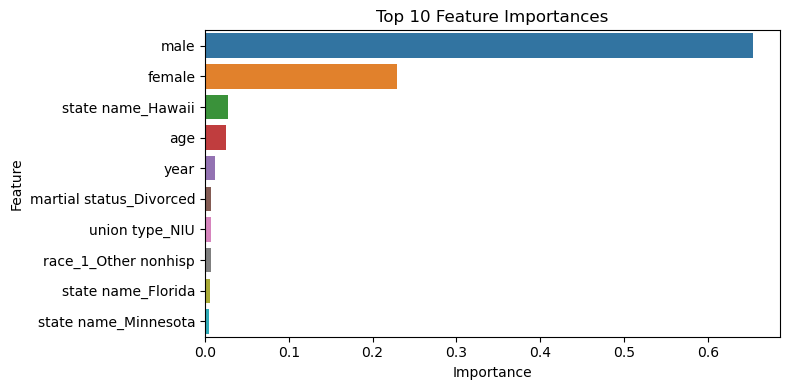

In [36]:
# Assuming X_train_clean.columns contains the feature names
feature_importances = model.feature_importances_

# Create a DataFrame with feature names and their importance scores
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance (most important features at the top)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))  # Show top 10 features
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [21]:
# Step 1: Calculate the average salary by year, state name, race, age, union type, and marital status
avg_income_data_less_features = (
    combined_df
    .groupBy(['year','age', 'sex_1'])
    .agg(F.mean('incwage').alias('avg_income'))  # Calculate average income
)
avg_income_data_less_features.show(5)


+----+---+------+------------------+
|year|age| sex_1|        avg_income|
+----+---+------+------------------+
|1981| 36|  male|21176.677279305353|
|1981| 60|  male| 18688.27683615819|
|1981| 37|  male|21364.150837988826|
|1981| 35|female|10368.572477064221|
|1981| 62|female|  8408.13294797688|
+----+---+------+------------------+
only showing top 5 rows



In [22]:
# Pivot to get male and female average incomes
avg_income_pivot_less_features = avg_income_data_less_features.groupBy(['year','age']).pivot('sex_1', ['male', 'female']).agg(F.first('avg_income'))
avg_income_pivot_less_features.show(5)

+----+---+------------------+-----------------+
|year|age|              male|           female|
+----+---+------------------+-----------------+
|2009| 50| 72941.98257372653|40710.38036809816|
|2007| 44| 59108.32947368421|37869.35555555556|
|1999| 42|48198.710743801654|         26580.65|
|1990| 53| 32923.18904109589|18208.58258258258|
|2011| 46| 63990.20870678617|41666.79802955665|
+----+---+------------------+-----------------+
only showing top 5 rows



In [23]:
# Calculate pay gap (percentage difference)
avg_income_pivot_less_features = avg_income_pivot_less_features.withColumn('pay_gap', 
    (avg_income_pivot_less_features['male'] - avg_income_pivot_less_features['female']) / avg_income_pivot_less_features['male'] * 100)

# Order and show final results
avg_income_pivot_less_features.orderBy('year', 'age').show(5)

+----+---+------------------+------------------+------------------+
|year|age|              male|            female|           pay_gap|
+----+---+------------------+------------------+------------------+
|1981| 25|13529.103213242453| 9360.390663390663|30.812925913458944|
|1981| 26|14301.984662576688| 9543.998777506113| 33.26801137971128|
|1981| 27|14866.549851924976| 9457.711026615969| 36.38260981318843|
|1981| 28|15898.320696721312|10065.381562099872|36.689026758809554|
|1981| 29| 17011.05642633229|10018.459039548023| 41.10619124136268|
+----+---+------------------+------------------+------------------+
only showing top 5 rows



In [24]:
# Convert to Pandas for scikit-learn model
avg_income_pandas_less_features = avg_income_pivot_less_features.orderBy('year').toPandas()
avg_income_pandas_less_features.head()

,year,age,male,female,pay_gap
0,1981,58,21213.308642,9611.429032,54.691514
1,1981,64,17084.826923,8362.919118,51.050607
2,1981,34,19720.022826,10133.969343,48.610763
3,1981,43,21364.170213,9601.723831,55.056884
4,1981,51,22493.271762,10857.176000,51.731451


In [25]:
# Data cleaning and preparation
avg_income_pandas_less_features.replace({'male': {'None': np.nan}, 'female': {'None': np.nan}, 'pay_gap': {'None': np.nan}}, inplace=True)
avg_income_pandas_less_features.fillna(0, inplace=True)

# Handle NaN variables
avg_income_pandas_less_features['male'].fillna('0', inplace=True)
avg_income_pandas_less_features['female'].fillna('0', inplace=True)
avg_income_pandas_less_features['pay_gap'].fillna('0', inplace=True)

# Convert necessary columns to float
avg_income_pandas_less_features['male'] = avg_income_pandas_less_features['male'].astype(float)
avg_income_pandas_less_features['female'] = avg_income_pandas_less_features['female'].astype(float)
avg_income_pandas_less_features['pay_gap'] = avg_income_pandas_less_features['pay_gap'].astype(float)



/var/folders/jz/_p_lld1s29s8d9d81cx0tzmw0000gn/T/ipykernel_22464/1818963439.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  avg_income_pandas_less_features['male'].fillna('0', inplace=True)
/var/folders/jz/_p_lld1s29s8d9d81cx0tzmw0000gn/T/ipykernel_22464/1818963439.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

In [26]:
# Define feature matrix (X) and target vector (y)
X_2 = avg_income_pandas_less_features.drop(columns=['pay_gap'])  # Dropping only pay_gap, which is the target
y_2 = avg_income_pandas_less_features['pay_gap']  # pay_gap is the target variable, which remains continuous


In [27]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)


In [28]:
# Standard scaling
scaler_2 = StandardScaler()
X_train_2 = scaler_2.fit_transform(X_train_2)
X_test_2 = scaler_2.transform(X_test_2)

In [29]:
# Initialize and fit the RandomForestRegressor model
model_2 = RandomForestRegressor()
model_2.fit(X_train_2, y_train_2)

RandomForestRegressor()

In [30]:
# Make predictions
y_pred_2 = model_2.predict(X_test_2)

In [31]:
# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test_2, y_pred_2))
print("R-squared:", r2_score(y_test_2, y_pred_2))

Mean Squared Error: 8.08841865676879
R-squared: 0.9235446422358619


In [32]:
# Print feature importances
updated_importances = model_2.feature_importances_
updated_feature_names = X_2.columns
updated_importance_df = pd.DataFrame({'Feature': updated_feature_names, 'Importance': updated_importances})
updated_importance_df = updated_importance_df.sort_values(by='Importance', ascending=False)
print("\nUpdated Feature Importances:")
print(updated_importance_df)


Updated Feature Importances:
  Feature  Importance
1     age    0.459381
3  female    0.389641
2    male    0.083774
0    year    0.067203


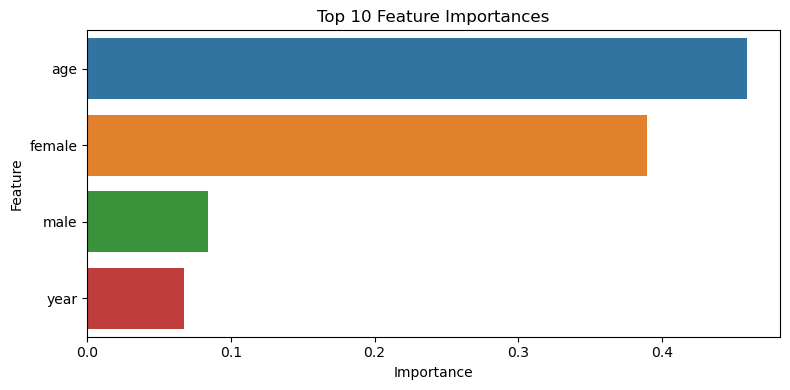

In [35]:
# Assuming X_train_clean.columns contains the feature names
updated_feature_importances = model_2.feature_importances_

# Create a DataFrame with feature names and their importance scores
updated_importance_df = pd.DataFrame({
    'Feature': updated_feature_names,
    'Importance': updated_feature_importances
})

# Sort the DataFrame by importance (most important features at the top)
updated_importance_df = updated_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=updated_importance_df.head(10))  # Show top 10 features
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
